In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import route_dynamics.route_elevation.base as base
import geopandas as gpd

from shapely.geometry import mapping

In [30]:
dat1 = pd.read_csv("../data/Trip183.csv")
dat2 = pd.read_csv("../data/Zon183Unsum.csv")

/Users/ryanjcarlin/miniconda3/envs/simple_route_dynamics/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
trip183 = dat1[['SignRt', 'InOut', 'KeyTrip', 'BusType', 'Seats',
                'Period', 'AnnRides']]

In [32]:
trip183unsum = dat2[['Route', 'Dir', 'Trip_ID', 'InOut', 'STOP_SEQ', 'STOP_ID',
                     'Period', 'AveOn', 'AveOff', 'AveLd', 'Obs']]

In [33]:
bus_mass = {
    11: 11000,
    26: 19051,
    32: 11793,
    36: 11793,
    37: 12247,
    43: 14913,
    45: 19051,
    46: 18835,
    60: 19051,
    62: 19051,
    68: 19051,
    70: 12927,
    72: 12927,
    73: 12927,
    80: 19051,
    81: 19051,
    82: 19051,
    90: 12927,
    91: 12927,
    92: 12927,
    95: 19051,
    96: 19051
        }

In [34]:
trip183 = trip183.replace({'BusType': bus_mass})
trip_mass = trip183[['BusType', 'KeyTrip']]
trip_dict = dict(zip(trip_mass.KeyTrip, trip_mass.BusType))

In [35]:
def route_ridership(period, direction, route):
    
    df = trip183unsum
    df = df.drop(df[(df.Period != period)].index)
    df = df.drop(df[(df.InOut != direction)].index)
    df = df.drop(df[(df.Route != route)].index)

    final_df = df.sort_values(by=['Trip_ID', 'STOP_SEQ', 'STOP_ID'])
    seq_id = final_df[['STOP_SEQ', 'STOP_ID']]
    seq_id2 = seq_id.drop_duplicates(subset=['STOP_SEQ'], keep='first')
    seq_id3 = seq_id2.sort_values(by='STOP_SEQ')
    stopid_dic = dict(zip(seq_id3.STOP_SEQ, seq_id3.STOP_ID))
    riders = final_df.pivot(index='STOP_SEQ', columns='Trip_ID', values='AveLd')

    keyfind = list(riders.columns)
    mass_bus = [trip_dict[x] for x in keyfind]
    mode = mode_mass = max(set(mass_bus), key=mass_bus.count)
    rider_columns = list(riders.columns)
    kept_columns = []

    for i in range(0, len(mass_bus)):
        if mass_bus[i] == mode:
            kept_columns.append(rider_columns[i])

    riders_interm = riders[kept_columns]
    riders_kept = pd.DataFrame((riders_interm.mean(axis=1)), columns=['Mean'])
    riders_kept.Mean*=80
    riders_kept.reset_index(inplace=True)
    riders_kept.replace({"STOP_SEQ": stopid_dic}, inplace=True)
    riders_kept.columns = ['STOP_ID', 'Mean']



    return final_df, riders_kept, mode_mass

In [36]:
df_45, riders_45, mass_45 = route_ridership('AM', 'I', 45)

In [10]:
riders_45

,STOP_ID,Mean
0,35530.0,43.692308
1,35540.0,74.461538
2,35550.0,94.153846
3,19210.0,122.461538
4,35551.0,158.769231
5,35570.0,193.846154
6,35580.0,227.076923
7,35600.0,353.846154
8,35630.0,404.307692
9,41430.0,516.307692


In [11]:
routes_shp = '../data/six_routes.shp'
stops_shp = '../data/Transit_Stops_for_King_County_Metro__transitstop_point.shp'

In [12]:
def stop_coord(num, riders_num):
    route_num = num
    
    route = base.read_shape(routes_shp, route_num)
    points = base.extract_point_df(route)
    stops = gpd.read_file(stops_shp)
    stops['ROUTE_LIST'].fillna(value=str(0), inplace=True)
    
    stops_list = pd.DataFrame()
    for i in range(0, len(stops)):
    
        if str(route_num) in (stops['ROUTE_LIST'][i]):
            for x in stops['ROUTE_LIST'][i].split(' '):
                if str(route_num) == x:
                    stops_list = stops_list.append(stops.iloc[i])
                else:
                    pass
        else:
            pass
        
    stop_ids = stops_list['STOP_ID'].values
    
    geometry = stops_list.geometry.values

    xy = []
    for i in range(len(geometry)):
        dic = mapping(geometry[i])
        coords = dic['coordinates']
        xy.append(coords)
        xy_df = pd.DataFrame(columns = ['STOP_ID','coordinates'])
        xy_df['coordinates'] = xy
    
    xy_df['STOP_ID'] = stops_list['STOP_ID'].values
    
    df = riders_num
    df_ind = df.reset_index()
    df_ind.columns = ['STOP_SEQ', 'STOP_ID', 'Mean']
    
    df_comb = xy_df.merge(df_ind, how='right', on="STOP_ID")
    df_comb = df_comb.drop_duplicates(subset=['STOP_ID'], keep='first')
    df_comb = df_comb[['STOP_SEQ', 'STOP_ID', 'coordinates', 'Mean']]
    df_combine = df_comb.sort_values(by='STOP_SEQ')
    
    return xy_df, df_combine

In [13]:
coordinates_45, final_45 = stop_coord(45, riders_45)

In [14]:
coordinates_45.head()

,STOP_ID,coordinates
0,5330.0,"(-122.35493491168019, 47.69052891200809)"
1,5350.0,"(-122.34960617887032, 47.6905094486964)"
2,5370.0,"(-122.34472418112374, 47.69049011915158)"
3,5380.0,"(-122.34150318558568, 47.69047109565094)"
4,5400.0,"(-122.33660476604088, 47.6904450549253)"


In [15]:
final_45.head()

,STOP_SEQ,STOP_ID,coordinates,Mean
56,0,35530.0,"(-122.39786618471946, 47.690295853436986)",43.692308
58,1,35540.0,"(-122.39653218098778, 47.690500893105884)",74.461538
60,2,35550.0,"(-122.3941645942555, 47.69050290761158)",94.153846
36,3,19210.0,"(-122.39161830818995, 47.69050457451431)",122.461538
62,4,35551.0,"(-122.38776029322838, 47.690506809007324)",158.769231


array([(-122.39786618471946, 47.690295853436986),
       (-122.39653218098778, 47.690500893105884),
       (-122.3941645942555, 47.69050290761158),
       (-122.39161830818995, 47.69050457451431),
       (-122.38776029322838, 47.690506809007324),
       (-122.38402033023164, 47.69051827478684),
       (-122.38186811567802, 47.69052450657306),
       (-122.37643891195872, 47.69054221241847),
       (-122.37003126702969, 47.690569566890574),
       (-122.36546698895918, 47.69058385834804),
       (-122.3602800879014, 47.690554760978245),
       (-122.35765616907172, 47.69053970873586),
       (-122.35493491168019, 47.69052891200809),
       (-122.34960617887032, 47.6905094486964),
       (-122.34472418112374, 47.69049011915158),
       (-122.34150318558568, 47.69047109565094),
       (-122.33660476604088, 47.6904450549253),
       (-122.33650469381267, 47.688530261542994),
       (-122.33647017353609, 47.687056340469276),
       (-122.33656263770621, 47.685480112620745),
       (-122.334

In [16]:
df_45_ami, riders_45ami, mass_45ami = route_ridership('AM', 'I', 45)
df_45amo, riders_45amo, mass_45amo = route_ridership('AM', 'O', 45)

In [17]:
df_45pmi, riders_45pmi, mass_45pmi = route_ridership('PM', 'I', 45)
df_45pmo, riders_45pmo, mass_45pmo = route_ridership('PM', 'O', 45)

In [18]:
riders_45pmi.head()

,STOP_ID,Mean
0,35530.0,101.647059
1,35540.0,112.000000
2,35550.0,121.333333
3,19210.0,132.888889
4,35551.0,153.333333


In [19]:
df_45ami, riders_45ami, mass_45ami = route_ridership('AM', 'I', 45)
df_45midi, riders_45midi, mass_45midi = route_ridership('MID', 'I', 45)
df_45pmi, riders_45pmi, mass_45pmi = route_ridership('PM', 'I', 45)
df_45xnti, riders_45xnti, mass_45xnti = route_ridership('XNT', 'I', 45)
df_45xevi, riders_45xevi, mass_45xevi = route_ridership('XEV', 'I', 45)

In [20]:
riders45ami = riders_45ami / 80
riders45midi = riders_45midi / 80
riders45pmi = riders_45pmi / 80
riders45xevi = riders_45xevi / 80
riders45xnti = riders_45xnti / 80

In [21]:
riders45pmo = riders_45pmo / 80
riders45pmi = riders_45pmi / 80

In [22]:
riders_45ami.head()

,STOP_ID,Mean
0,35530.0,43.692308
1,35540.0,74.461538
2,35550.0,94.153846
3,19210.0,122.461538
4,35551.0,158.769231


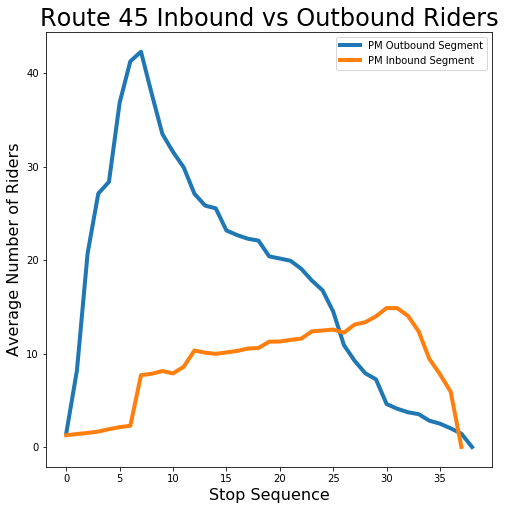

In [23]:
plt.figure(figsize=(8,8))
plt.plot(riders45pmo['Mean'], label='PM Outbound Segment', linewidth=4)
plt.plot(riders45pmi['Mean'], label='PM Inbound Segment', linewidth=4)
plt.legend()
plt.xlabel('Stop Sequence', size=16)
plt.ylabel('Average Number of Riders', size=16)
plt.title('Route 45 Inbound vs Outbound Riders', size=24)
plt.savefig('Outbound_Inbound_45.png', dpi=300)

Text(0.5, 1.0, 'Number of Riders on Route 45 (Inbound)')

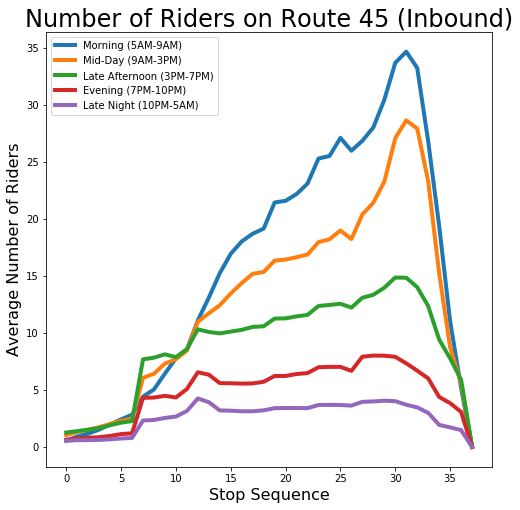

In [24]:
plt.figure(figsize=(8,8))
AM_plot = plt.plot(riders45ami['Mean'], label='Morning (5AM-9AM)', linewidth=4)
MID_plot = plt.plot(riders45midi['Mean'], label='Mid-Day (9AM-3PM)', linewidth=4)
PM_plot = plt.plot(riders45pmi['Mean'], label='Late Afternoon (3PM-7PM)', linewidth=4)
XEV_plot = plt.plot(riders45xevi['Mean'], label='Evening (7PM-10PM)', linewidth=4)
XNT_plot = plt.plot(riders45xnti['Mean'], label='Late Night (10PM-5AM)', linewidth=4)
plt.legend()
plt.xlabel('Stop Sequence', size=16)
plt.ylabel('Average Number of Riders', size=16)
plt.title('Number of Riders on Route 45 (Inbound)', size=24)
#plt.savefig('Ridership_daysegments.png', dpi=300)

In [25]:
df_45amo, riders_45amo, mass_45amo = route_ridership('AM', 'O', 45)
df_45mido, riders_45mido, mass_45mido = route_ridership('MID', 'O', 45)
df_45pmo, riders_45pmo, mass_45pmo = route_ridership('PM', 'O', 45)
df_45xevo, riders_45xevo, mass_45xevo = route_ridership('XEV', 'O', 45)
df_45xnto, riders_45xnto, mass_45xnto = route_ridership('XNT', 'O', 45)

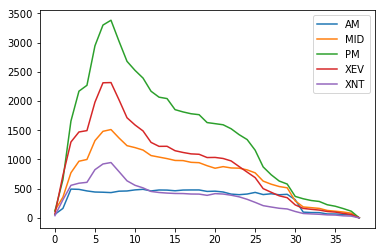

In [26]:
AM_ploto = plt.plot(riders_45amo['Mean'], label='AM')
MID_ploto = plt.plot(riders_45mido['Mean'], label='MID')
PM_ploto = plt.plot(riders_45pmo['Mean'], label='PM')
XEV_ploto = plt.plot(riders_45xevo['Mean'], label='XEV')
XNT_ploto = plt.plot(riders_45xnto['Mean'], label='XNT')
plt.legend()